In [5]:
# Part 1: Imports and Data Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy import stats
import tensorflow as tf
import logging
import warnings


# Suppress warnings and logging output
warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')


# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, skiprows=[1])
    df = df.set_index('Country Name').drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).T
    df.index = pd.date_range(start=str(df.index[0].split('.')[0]), periods=len(df), freq='Y')
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

    
# Feature engineering
def engineer_features(data):
    print("Initial data shape:", data.shape)
    data = pd.to_numeric(data, errors='coerce').dropna()

    if len(data) == 0:
        raise ValueError("No valid numeric data after conversion")

    print("Data shape after numeric conversion:", data.shape)

    # Adding lag features
    data = pd.DataFrame(data)
    data['lag_1'] = data.iloc[:, 0].shift(1)
    data['lag_2'] = data.iloc[:, 0].shift(2)

    # Adding rolling statistics
    data['rolling_mean'] = data.iloc[:, 0].rolling(window=3).mean()
    data['rolling_std'] = data.iloc[:, 0].rolling(window=3).std()

    result = data.dropna()
    if len(result) == 0:
        raise ValueError("No data left after feature engineering")

    print("Final engineered data shape:", result.shape)
    return result

    
# Load and prepare data
gdp_data = load_and_preprocess_data('BRICSGDP.csv')
brics_countries = ['Brazil', 'China', 'India', 'Russian Federation', 'South Africa']
gdp_data = gdp_data[brics_countries].interpolate(method='linear')

print("GDP Data Info:")
print(gdp_data.info())
print("\nGDP Data Head:")
print(gdp_data.head())
print("\nGDP Data Describe:")
print(gdp_data.describe())

# Engineer features for each country
engineered_data = {}
for country in brics_countries:
    # Initialise the engineered data for the country
    engineered_data[country] = None  # Start with None to check later
    try:
        print(f"\nAttempting to engineer features for {country}")
        engineered_data[country] = engineer_features(gdp_data[country])
        print(f"Successfully engineered features for {country}")
    except Exception as e:
        print(f"Error engineering features for {country}: {str(e)}")
        print(f"Data for {country}:")
        print(gdp_data[country])
        engineered_data[country] = pd.DataFrame(gdp_data[country])
    
    # Check for NaNs after attempting to engineer features
    if engineered_data[country] is not None:
        print(f"{country} engineered data NaNs:", engineered_data[country].isna().sum().sum())

# Part 2: Model Definitions
def fit_sarima(data):
    try:
        tscv = TimeSeriesSplit(n_splits=5)
        mse_list = []
        
        for train_index, test_index in tscv.split(data):
            train, test = data.iloc[train_index], data.iloc[test_index]
            model = auto_arima(train, seasonal=False, suppress_warnings=True, error_action="ignore", stepwise=True)
            mse = mean_squared_error(test, model.predict(n_periods=len(test)))
            mse_list.append(mse)
        
        print(f"Average MSE over 5 folds: {np.mean(mse_list):.4f}")
        return model
    except Exception as e:
        print(f"SARIMA model fitting failed: {str(e)}")
        return None

def fit_ets(data):
    try:
        model = ExponentialSmoothing(data, trend='add').fit()
        return model
    except Exception as e:
        print(f"ETS model fitting failed: {str(e)}")
        return None

def fit_var(data):
    try:
        if data.ndim == 1:
            data = data.to_frame()

        model = VAR(data)
        results = model.fit()
        return results
    except Exception as e:
        print(f"VAR model fitting failed: {str(e)}")
        return None

def fit_prophet(data):
    df = pd.DataFrame({'ds': data.index, 'y': data.values})
    model = Prophet(n_changepoints=3, changepoint_prior_scale=0.05)
    model.fit(df)
    return model

def fit_lstm(data):
    scaler = lambda x: stats.zscore(x.values if isinstance(x, pd.Series) else x)
    scaled_data = scaler(data)
    X, y = [], []
    
    # Prepare input and output sequences
    for i in range(len(scaled_data) - 5):
        X.append(scaled_data[i:i+5].reshape(5, 1))  # Reshape to (time steps, features)
        y.append(scaled_data[i+5])
    
    X, y = np.array(X), np.array(y)
    print("LSTM input shape:", X.shape, "LSTM output shape:", y.shape)

    
    # Define the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(5, 1)),
        Dense(1)
    ])
    
    # Compile the model with the legacy Adam optimizer
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')
    
    # Fit the model
    model.fit(X, y, epochs=100, verbose=0)
    
    return model, scaler

# Part 3: Forecasting Functions
def forecast_sarima(model, steps):
    try:
        forecast = model.predict(n_periods=steps)
        return forecast
    except Exception as e:
        print(f"Forecasting failed for SARIMA: {str(e)}")
        return None

def forecast_ets(model, steps):
    try:
        mean_forecast = model.forecast(steps)
        return mean_forecast
    except Exception as e:
        print(f"Forecasting failed for ETS: {str(e)}")
        return None

def forecast_var(model, steps, data):
    try:
        if data.ndim == 1:
            data = data.to_frame()

        last_observations = data.values[-model.k_ar:]
        forecast = model.forecast(y=last_observations, steps=steps)
        return pd.Series(forecast.flatten())
    except Exception as e:
        print(f"Forecasting failed for VAR: {str(e)}")
        return None

def forecast_prophet(model, steps):
    future = model.make_future_dataframe(periods=steps, freq='Y')
    forecast = model.predict(future)
    return forecast['yhat'].values[-steps:]

def forecast_lstm(model, scaler, data, steps):
    last_sequence = scaler(data[-5:]).reshape(1, 5, 1)
    forecast = []
    for _ in range(steps):
        next_pred = model.predict(last_sequence)[0][0]
        forecast.append(next_pred)
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = next_pred
    return scaler(data)[-1] + np.array(forecast)


    
# Part 4: Ensemble and Evaluation
def ensemble_forecast(forecasts):
    forecast_length = 6  # Fixed forecast length
    padded_forecasts = []
    
    for f in forecasts:
        if f is not None:
            f = pd.Series(f) if isinstance(f, np.ndarray) else f
            padded = f[:forecast_length].reindex(range(forecast_length), fill_value=np.nan)
            padded_forecasts.append(padded)

    if not padded_forecasts:
        raise ValueError("No valid forecasts provided")
    
    ensemble_result = pd.concat(padded_forecasts, axis=1).mean(axis=1)
    return ensemble_result


# Forecasting for each country
forecast_steps = 6  # Next 6 years
for country in brics_countries:
    print(f"\nForecasting GDP for {country}:")
    data = engineered_data[country].iloc[:, 0] 

    # Fit models
    sarima_model = fit_sarima(data)
    ets_model = fit_ets(data)
    var_model = fit_var(engineered_data[country])  
    prophet_model = fit_prophet(data)
    lstm_model, lstm_scaler = fit_lstm(data)

    
    # Generate forecasts
    sarima_forecast = forecast_sarima(sarima_model, forecast_steps)
    ets_forecast = forecast_ets(ets_model, forecast_steps)
    var_forecast = forecast_var(var_model, forecast_steps, engineered_data[country])
    prophet_forecast = forecast_prophet(prophet_model, forecast_steps)
    lstm_forecast = forecast_lstm(lstm_model, lstm_scaler, data, forecast_steps)

    # Print each forecast to debug
    print(f"SARIMA Forecast: {sarima_forecast}")
    print(f"ETS Forecast: {ets_forecast}")
    print(f"VAR Forecast: {var_forecast}")
    print(f"Prophet Forecast: {prophet_forecast}")
    print(f"LSTM Forecast: {lstm_forecast}")

    # Compile forecasts
    forecasts = [sarima_forecast, ets_forecast, var_forecast, prophet_forecast, lstm_forecast]
    final_forecast = ensemble_forecast(forecasts)

GDP Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 1990-12-31 to 2023-12-31
Freq: A-DEC
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brazil              34 non-null     float64
 1   China               34 non-null     float64
 2   India               34 non-null     float64
 3   Russian Federation  34 non-null     float64
 4   South Africa        34 non-null     float64
dtypes: float64(5)
memory usage: 1.6 KB
None

GDP Data Head:
Country Name    Brazil      China     India  Russian Federation  South Africa
1990-12-31   -4.350000   3.920251  5.533455           -2.999996     -0.317760
1991-12-31    1.032190   9.262786  1.056831           -5.046939     -1.018245
1992-12-31   -0.544072  14.224530  5.482396          -14.531074     -2.137033
1993-12-31    4.924690  13.883729  4.750776           -8.668540      1.233558
1994-12-31    5.852870  13.036807  6.658924          -12.

In [8]:
# Part 5: Forecast Evaluation

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = mean_absolute_percentage_error(actual, forecast)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Use the last 6 years of available data for evaluation
evaluation_period = gdp_data.loc['2018':'2023']

# Dictionary to store evaluation results
evaluation_results = {country: {} for country in brics_countries}

def create_ensemble(forecasts):
    forecast_length = 6  # Fixed forecast length
    padded_forecasts = []
    
    for f in forecasts:
        if f is not None:
            f = pd.Series(f) if isinstance(f, np.ndarray) else f
            padded = f[:forecast_length].reindex(range(forecast_length), fill_value=np.nan)
            padded_forecasts.append(padded)

    if not padded_forecasts:
        raise ValueError("No valid forecasts provided")
    
    ensemble_result = pd.concat(padded_forecasts, axis=1).mean(axis=1)
    return ensemble_result

for country in brics_countries:
    print(f"\nEvaluation metrics for {country}:")
    
    # Actual values for this country
    actual = evaluation_period[country].values
    
    # Generate "forecasts" for the evaluation period using each model
    data = engineered_data[country].iloc[:, 0]
    
    sarima_forecast = forecast_sarima(fit_sarima(data[:'2017']), steps=6)
    ets_forecast = forecast_ets(fit_ets(data[:'2017']), steps=6)
    var_forecast = forecast_var(fit_var(engineered_data[country].loc[:'2017']), steps=6, data=engineered_data[country].loc[:'2017'])
    prophet_forecast = forecast_prophet(fit_prophet(data[:'2017']), steps=6)
    lstm_model, lstm_scaler = fit_lstm(data[:'2017'])
    lstm_forecast = forecast_lstm(lstm_model, lstm_scaler, data[:'2017'], steps=6)
    
    # Combine forecasts for ensemble
    forecasts = [sarima_forecast, ets_forecast, var_forecast, prophet_forecast, lstm_forecast]
    ensemble_forecast = create_ensemble(forecasts)
    
    forecasts = {
        'SARIMA': sarima_forecast,
        'ETS': ets_forecast,
        'VAR': var_forecast,
        'Prophet': prophet_forecast,
        'LSTM': lstm_forecast,
        'Ensemble': ensemble_forecast
    }
    
    for model_name, forecast in forecasts.items():
        # Ensure forecast is a numpy array
        forecast_array = np.array(forecast)
        
        # Check if lengths match, if not, adjust
        if len(forecast_array) != len(actual):
            forecast_array = forecast_array[:len(actual)]
        
        metrics = evaluate_forecast(actual, forecast_array)
        evaluation_results[country][model_name] = metrics
        print(f"Metrics for {model_name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print()


Evaluation metrics for Brazil:
Average MSE over 5 folds: 9.0958
LSTM input shape: (21, 5, 1) LSTM output shape: (21,)
1/1 [==============================] - 0s 17ms/step
Metrics for SARIMA:
MAE: 2.0101
RMSE: 2.9184
MAPE: 0.8270

Metrics for ETS:
MAE: 2.1940
RMSE: 2.6795
MAPE: 0.6646

Metrics for VAR:
MAE: 0.9414
RMSE: 1.8971
MAPE: 0.2538

Metrics for Prophet:
MAE: 2.1219
RMSE: 2.6205
MAPE: 0.6332

Metrics for LSTM:
MAE: 3.5159
RMSE: 3.7230
MAPE: 1.3403

Metrics for Ensemble:
MAE: 2.0942
RMSE: 2.4637
MAPE: 0.6845


Evaluation metrics for China:
Average MSE over 5 folds: 5.2151
LSTM input shape: (21, 5, 1) LSTM output shape: (21,)
1/1 [==============================] - 0s 19ms/step
Metrics for SARIMA:
MAE: 3.8782
RMSE: 4.5141
MAPE: 1.1585

Metrics for ETS:
MAE: 1.5854
RMSE: 2.1702
MAPE: 0.4916

Metrics for VAR:
MAE: 2.1778
RMSE: 2.5581
MAPE: 0.6546

Metrics for Prophet:
MAE: 2.4210
RMSE: 2.7934
MAPE: 0.7264

Metrics for LSTM:
MAE: 7.8328
RMSE: 8.1169
MAPE: 1.6057

Metrics for Ensemble:



Forecasting GDP for Brazil:
Average MSE over 5 folds: 8.7116
LSTM input shape: (27, 5, 1) LSTM output shape: (27,)
1/1 [==============================] - 0s 16ms/step
SARIMA forecast shape: (6,)
ETS forecast shape: (6,)
VAR forecast shape: (30,)
Prophet forecast shape: (6,)
LSTM forecast shape: (6,)


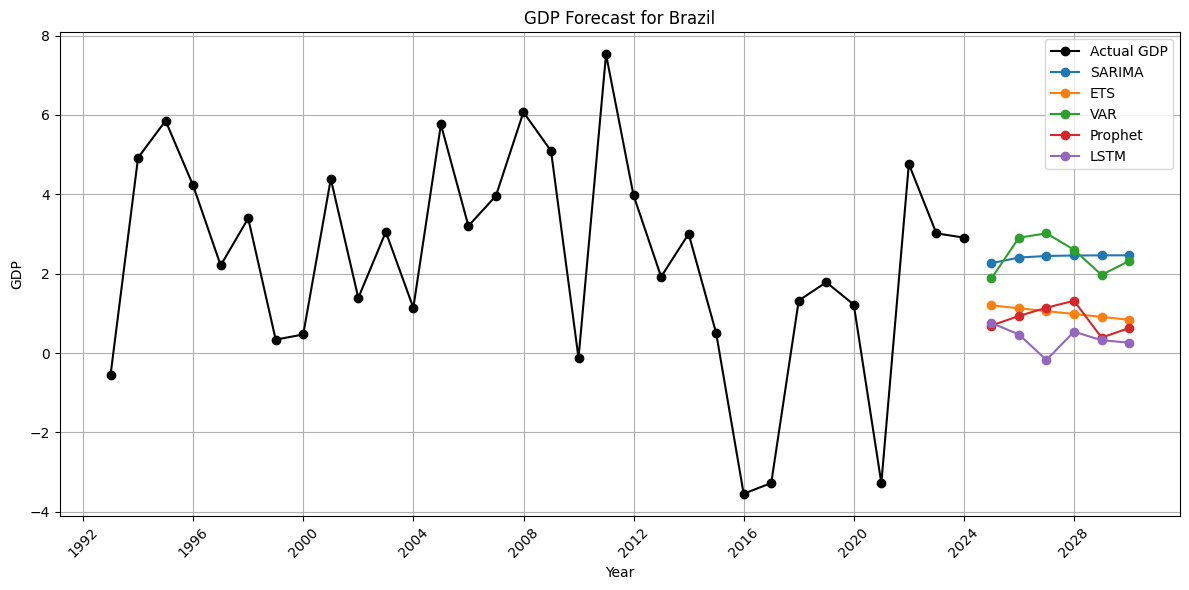


Forecasting GDP for China:
Average MSE over 5 folds: 4.7678
LSTM input shape: (27, 5, 1) LSTM output shape: (27,)
1/1 [==============================] - 0s 17ms/step
SARIMA forecast shape: (6,)
ETS forecast shape: (6,)
VAR forecast shape: (30,)
Prophet forecast shape: (6,)
LSTM forecast shape: (6,)


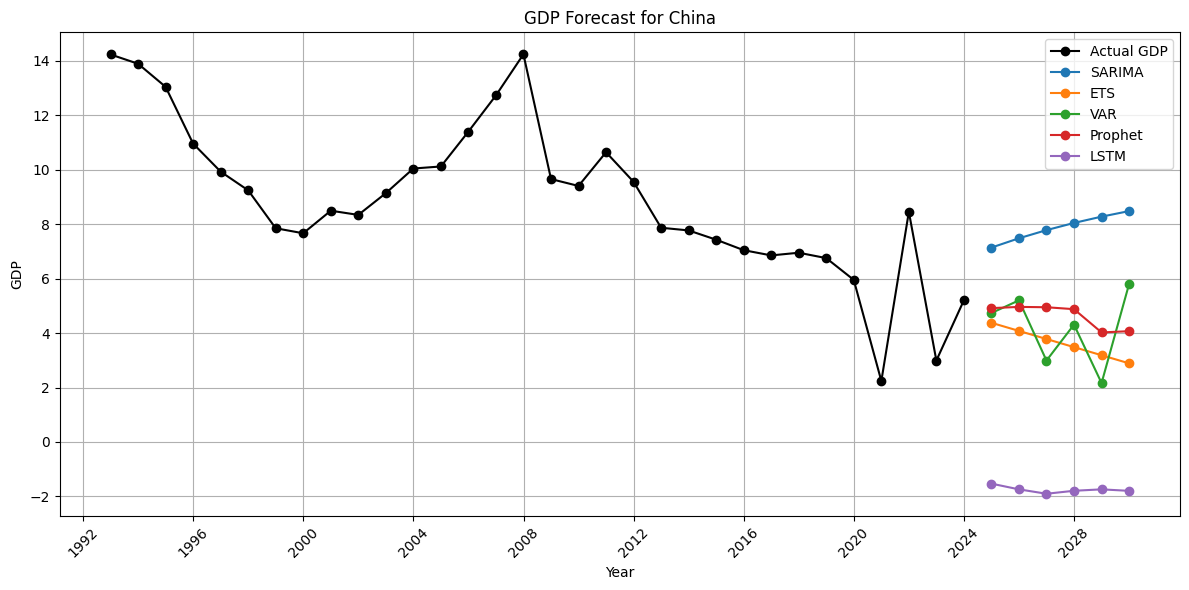


Forecasting GDP for India:
Average MSE over 5 folds: 9.2947
LSTM input shape: (27, 5, 1) LSTM output shape: (27,)
1/1 [==============================] - 0s 13ms/step
SARIMA forecast shape: (6,)
ETS forecast shape: (6,)
VAR forecast shape: (30,)
Prophet forecast shape: (6,)
LSTM forecast shape: (6,)


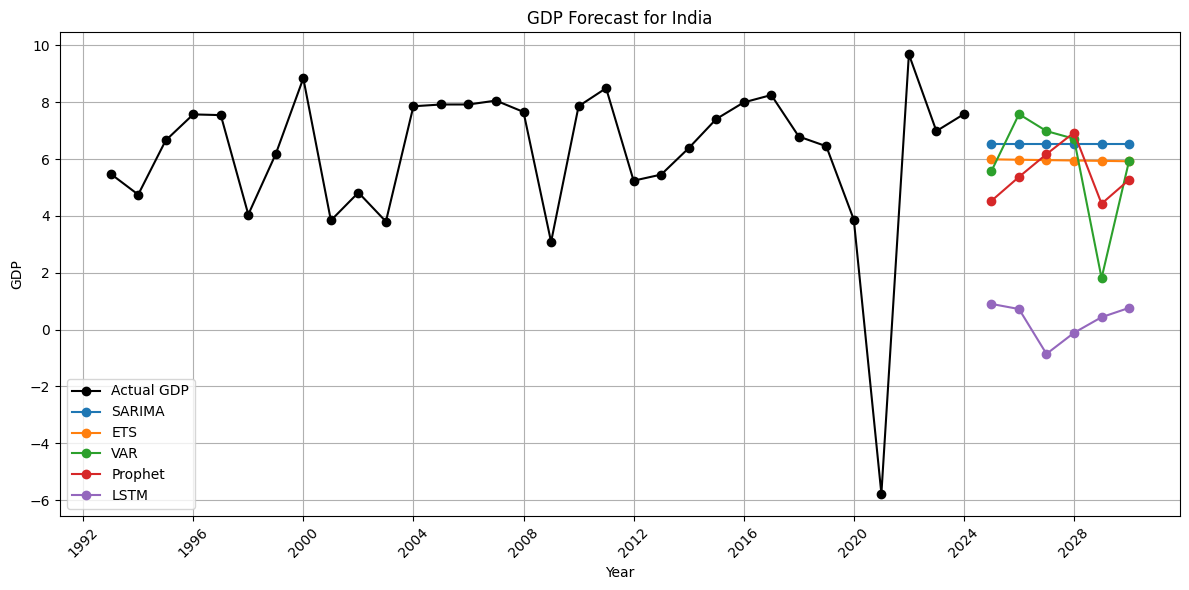


Forecasting GDP for Russian Federation:
Average MSE over 5 folds: 52.9218
LSTM input shape: (27, 5, 1) LSTM output shape: (27,)
1/1 [==============================] - 0s 15ms/step
SARIMA forecast shape: (6,)
ETS forecast shape: (6,)
VAR forecast shape: (30,)
Prophet forecast shape: (6,)
LSTM forecast shape: (6,)


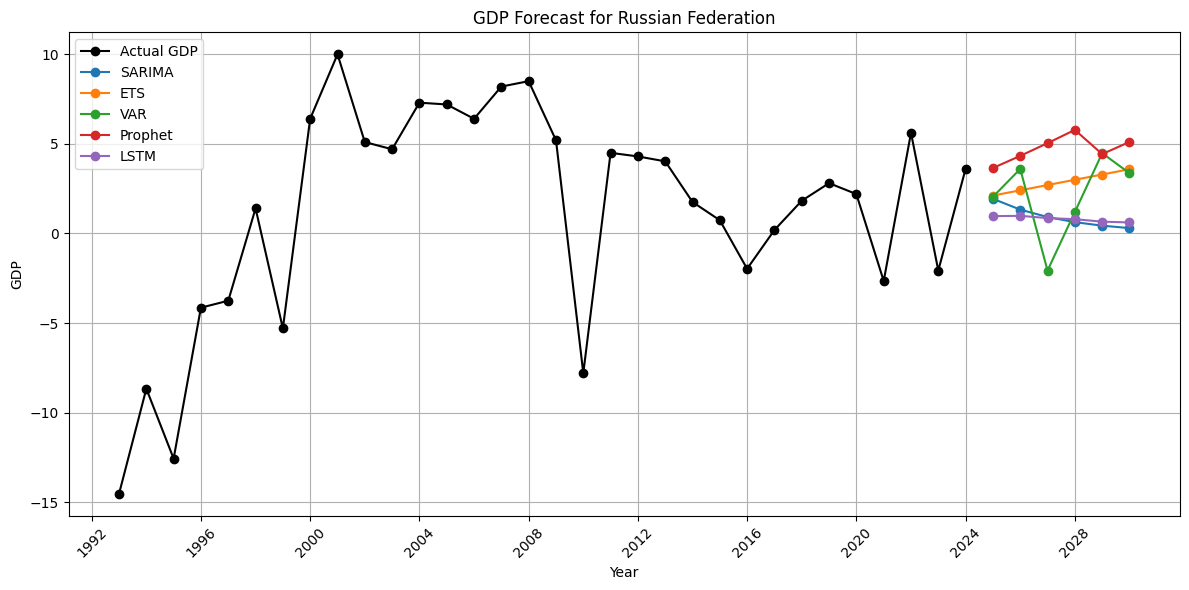


Forecasting GDP for South Africa:
Average MSE over 5 folds: 10.8369
LSTM input shape: (27, 5, 1) LSTM output shape: (27,)
1/1 [==============================] - 0s 16ms/step
SARIMA forecast shape: (6,)
ETS forecast shape: (6,)
VAR forecast shape: (30,)
Prophet forecast shape: (6,)
LSTM forecast shape: (6,)


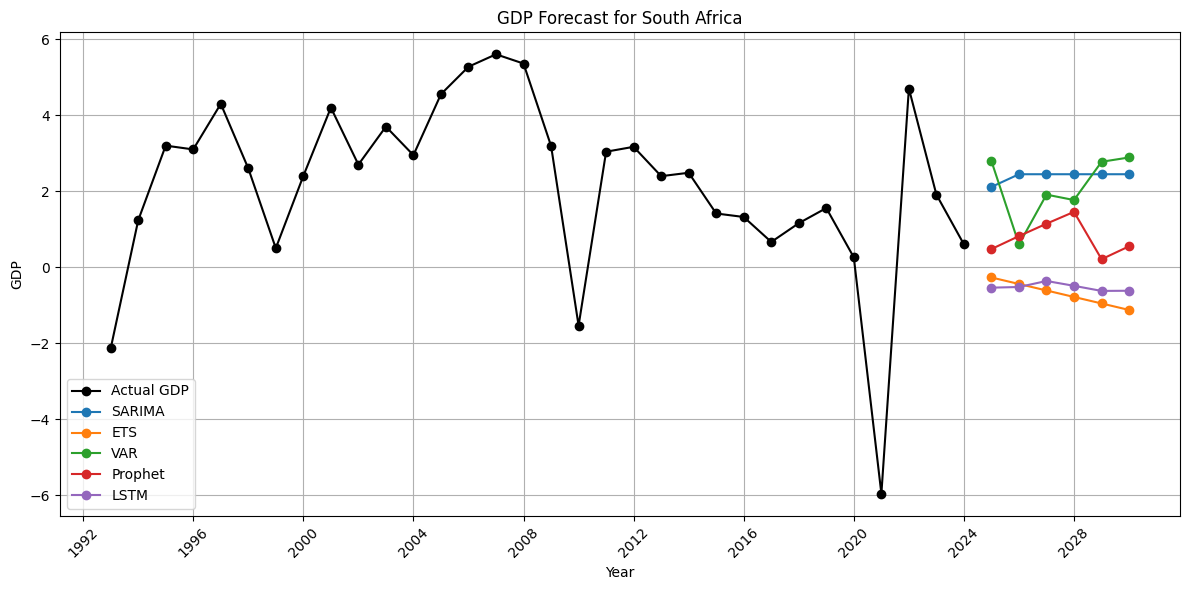

In [12]:
def plot_forecasts(country, actual, forecasts, steps):
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    plt.plot(actual.index, actual, label='Actual GDP', color='black', marker='o')
    
    # Generate future index for the forecasted years
    future_index = pd.date_range(start=actual.index[-1] + pd.DateOffset(years=1), 
                                  periods=steps, freq='Y')
    
    # Plot forecasts from each model
    model_labels = ['SARIMA', 'ETS', 'VAR', 'Prophet', 'LSTM']
    
    for forecast, label in zip(forecasts, model_labels):
        # Check the shape of forecast before plotting
        print(f"{label} forecast shape: {forecast.shape}")

        # Ensure the forecast length matches the future index length
        if len(forecast) != len(future_index):
            print(f"Warning: {label} forecast length {len(forecast)} does not match future index length {len(future_index)}. Trimming forecast.")
            forecast = forecast[:len(future_index)]  # Trim or adjust forecast as necessary
        
        plt.plot(future_index, forecast, label=label, marker='o')

    plt.title(f'GDP Forecast for {country}')
    plt.xlabel('Year')
    plt.ylabel('GDP')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

# Forecasting for each country and plotting
forecast_steps = 6  # Next 6 years
for country in brics_countries:
    print(f"\nForecasting GDP for {country}:")
    data = engineered_data[country].iloc[:, 0] 

    # Fit models
    sarima_model = fit_sarima(data)
    ets_model = fit_ets(data)
    var_model = fit_var(engineered_data[country])  
    prophet_model = fit_prophet(data)
    lstm_model, lstm_scaler = fit_lstm(data)

    # Generate forecasts
    sarima_forecast = forecast_sarima(sarima_model, forecast_steps)
    ets_forecast = forecast_ets(ets_model, forecast_steps)
    var_forecast = forecast_var(var_model, forecast_steps, engineered_data[country])
    prophet_forecast = forecast_prophet(prophet_model, forecast_steps)
    lstm_forecast = forecast_lstm(lstm_model, lstm_scaler, data, forecast_steps)

    # Compile forecasts
    forecasts = [sarima_forecast, ets_forecast, var_forecast, prophet_forecast, lstm_forecast]
    
    # Prepare actual data for plotting
    actual_data = data
    actual_index = actual_data.index

    # Plot the forecasts
    plot_forecasts(country, actual_data, forecasts, forecast_steps)
